## Comparing Auto Encoders

In the previous tutorials, we trained two autoencoders to compress hand written digits into a single, 10-long floating point number per digit.  The first network was a standard fully connected neural network, and the second was a much smaller convolutional neural network - about 10x smaller in trainable parameters.

Which was better?  It's hard to answer that question just from looking at a few output images, and certainly examining the intermediate representation by eye is not super useful.  In this notebook we'll try two techniques to measure just "how good" the autoencoder/decoder pairs are doing:

1) Comparision of Mean Squared Error on validation set

2) Comparision of performance of classification network on decoded images



In [1]:
# This is the same from noteboook 2:
# Load the data generator and tensorflow:

LOAD_PRETRAINED_MODELS=True
MODEL_PREFIX = "saved_models/pretrained/"

import tensorflow as tf
import numpy
tf.enable_eager_execution()
from src.utils import data_generator

from src.models import convolutional_AE
from src.models import neural_net_AE




In [2]:
data_gen = data_generator.mnist_generator()

fc_encoder   = neural_net_AE.Encoder()
conv_encoder = convolutional_AE.Encoder()

fc_decoder   = neural_net_AE.Decoder(1)
conv_decoder = convolutional_AE.Decoder()



Like in the other notebooks, the models are not really initialized until you go through them once with input data.  So we will run through once for each model to make sure they are initialized, then we can load them:

In [3]:
# Restore the trained models for each of the networks:
BATCH_SIZE=1
NUM_DIGITS=1

data_gen = data_generator.mnist_generator()

# Load some data:
batch_images, batch_labels = data_gen.next_train_batch(BATCH_SIZE, NUM_DIGITS)
# Reshape the data:
fc_batch_images = batch_images.reshape([BATCH_SIZE, 28*28*NUM_DIGITS])

fc_intermediate_state = fc_encoder(fc_batch_images)
fc_decoded_images = fc_decoder(fc_intermediate_state)

conv_batch_images = batch_images.reshape([BATCH_SIZE, 28, 28*NUM_DIGITS, 1])


conv_intermediate_state = conv_encoder(conv_batch_images)
conv_decoded_images = conv_decoder(conv_intermediate_state)



fc_encoder.load_weights(MODEL_PREFIX + "nn_encoder.h5")
fc_decoder.load_weights(MODEL_PREFIX + "nn_decoder.h5")
conv_encoder.load_weights(MODEL_PREFIX + "conv_encoder.h5")
conv_decoder.load_weights(MODEL_PREFIX + "conv_decoder.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# We will skip the data generator since this is single image autoencoding.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype(numpy.float64) * (1./256)
x_test  = x_test.astype(numpy.float64) * (1./256)




fc_x_test = x_test.reshape(10000, 28*28).astype(numpy.float64)
conv_x_test = x_test.reshape(10000, 28, 28, 1).astype(numpy.float64)

In [5]:
fc_intermediate_state = fc_encoder(fc_x_test)
fc_decoded = fc_decoder(fc_intermediate_state)

conv_intermediate_state = conv_encoder(conv_x_test)
conv_decoded = conv_decoder(conv_intermediate_state)

In [6]:
fc_loss = tf.losses.mean_squared_error(fc_x_test, fc_decoded)
conv_loss = tf.losses.mean_squared_error(conv_x_test, conv_decoded)

Instructions for updating:
Use tf.cast instead.


In [7]:
print("Fully connected test loss: ", fc_loss.numpy())
print("Convolutional test loss: ", conv_loss.numpy())

Fully connected test loss:  0.013315595
Convolutional test loss:  0.013631473


Which is better?  Depending on how the training went, it is hard to tell.  The pretrained models will tell you that the fully connected model is marginally, but not impactfully, better.

### Classifying decoded data

Let's look at another comparison.  We'll quickly spin up a classifier for mnist digits and then see how well the decoded data is doing at recreating it's original state by classifying the output of the decoder.

There is an mnist model ready to run in the models folder, so let's load and use that:

In [8]:
from src.models import mnist_classifier

model = mnist_classifier.mnist_classifier(n_output=10)


In [9]:
TRAIN_CLASSIFIER = False
if TRAIN_CLASSIFIER:
    N_TRAINING_ITERATION = 1500
    BATCH_SIZE = 200
    data_gen = data_generator.mnist_generator()

    optimizer = tf.train.AdamOptimizer()

    loss_history = []
    val_loss_history = []
    val_steps = []

    for i in range(N_TRAINING_ITERATION):

        # Load some data:
        training_batch_images, training_batch_labels = data_gen.next_train_batch(BATCH_SIZE, NUM_DIGITS)
        # Reshape the data:
        training_batch_images = training_batch_images.reshape(
            [BATCH_SIZE, 28, 28*NUM_DIGITS, 1])

        with tf.GradientTape() as tape:
            logits = model(training_batch_images)
            loss_value = tf.losses.sparse_softmax_cross_entropy(training_batch_labels, logits)


        trainable_vars = model.trainable_variables


        loss_history.append(loss_value.numpy())

        # Apply the update to the model:
        grads = tape.gradient(loss_value, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars),
                                 global_step=tf.train.get_or_create_global_step())

        if i % 5 == 0:
            print("Step {}, loss {}".format(i, loss_history[-1]))
else:
    training_batch_images, training_batch_labels = data_gen.next_train_batch(1, NUM_DIGITS)
    logits = model(batch_images.reshape(1, 28, 28, 1))
    model.load_weights(MODEL_PREFIX + "mnist_classifier.h5")

In [10]:
val_images, val_labels = data_gen.next_test_batch(512, 1)
val_images = val_images.reshape(512, 28, 28 ,1)
logits = model(val_images)

In [11]:
predicted_label = numpy.argmax(logits, axis=-1)
acc = val_labels == predicted_label

In [12]:
val_loss = tf.losses.sparse_softmax_cross_entropy(val_labels, logits)

In [13]:
print("Classification loss of mnist classifier model: ", val_loss)
print("Classification accuracy on small subset of test set: ", numpy.mean(acc))

Classification loss of mnist classifier model:  tf.Tensor(0.0449499674141407, shape=(), dtype=float64)
Classification accuracy on small subset of test set:  0.986328125


For what it's worth, this accuracy on MNIST is nothing special.  But it's plenty good for the rest of this demo.

We have the decoded versions of the validation sets for both the fully connected and convolutional networks.  Let's run our classifier on the original images, the decoded images, and compare the accuracies for both as well as the "recall" ability (as judged by our classifier) to produce the same digit after the encoder/decoder pass:


In [30]:
x_test.shape
classified_original_images = model(x_test.reshape(10000,28,28,1))
original_predicted_classes = numpy.argmax(classified_original_images, axis=-1)

In [31]:
classified_fc_encoded_images = model(tf.reshape(fc_decoded, (10000,28,28,1)))
fc_predicted_classes = numpy.argmax(classified_fc_encoded_images, axis=-1)

In [32]:
classified_conv_encoded_imagegs = model(tf.reshape(conv_decoded, (10000,28,28,1)))
conv_predicted_classes = numpy.argmax(classified_conv_encoded_imagegs, axis=-1)

In [33]:
original_predicted_classes.shape

(10000,)

In [41]:
print("Total accuracy on original dataset: ", numpy.mean(y_test == original_predicted_classes) )
print("Total accuracy after F.C. encoding: ", numpy.mean(y_test == fc_predicted_classes) )
print("Total accuracy after Conv. encoding: ", numpy.mean(y_test == conv_predicted_classes) )
print("Agreement between encodings: ", numpy.mean(fc_predicted_classes == conv_predicted_classes) )

Total accuracy on original dataset:  0.9841
Total accuracy after F.C. encoding:  0.9558
Total accuracy after Conv. encoding:  0.9497
Agreement between encodings:  0.9608


Based on this, we see that the fully connected encoder is outperforming the convolutional encoder slightly, not just in loss during training but also in ability to reproduce images of the same class.

The two encoders generally produce images that are slightly less easy for the convolutional classifier to identify.  Interestingly, they are given the same category (right or wrong) 96% of the time, and 4% of the time they diverge into a different category.

One outstanding question is: how do we tell if a number is being misclassified because of the encoder or because of the classifier?  Let's compare predictions before and after encoding:

In [43]:
print("F.C. Agreement before/after encoding: ", numpy.mean(fc_predicted_classes == original_predicted_classes) )
print("Conv. Agreement before/after encoding: ", numpy.mean(conv_predicted_classes == original_predicted_classes) )



F.C. Agreement before/after encoding:  0.9596
Conv. Agreement before/after encoding:  0.9536


Almost identical!  Before wrapping up, let's look at some images that are changing categories:

In [47]:
conv_changed_images = conv_predicted_classes != original_predicted_classes

In [62]:
pre_images = x_test[conv_changed_images]


In [60]:
temp = conv_decoded.numpy()
post_images = temp[conv_changed_images]


In [63]:
from matplotlib import pyplot as plt
%matplotlib inline


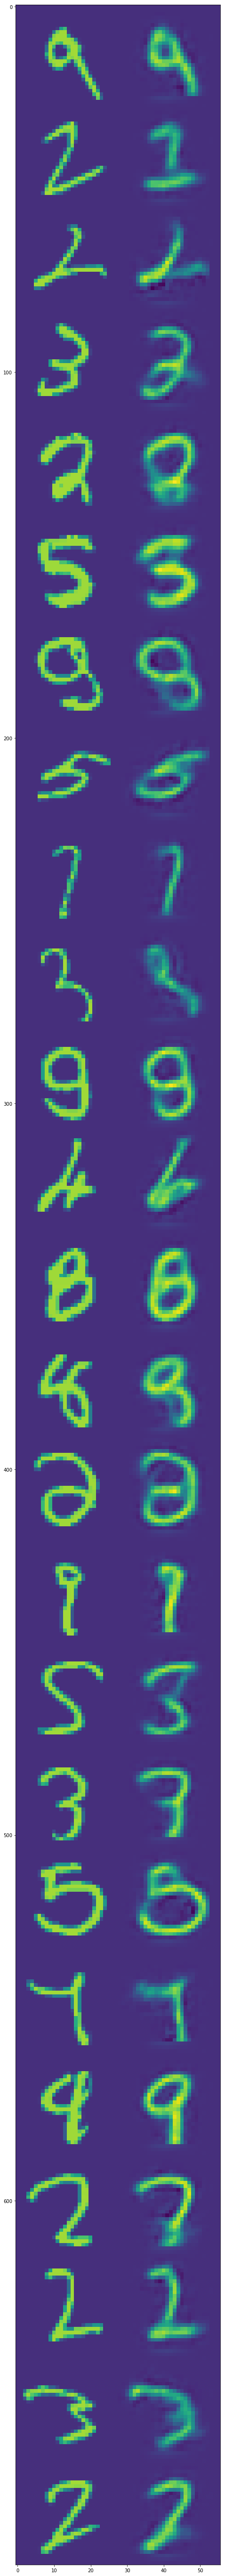

In [75]:
fig = plt.figure(figsize=(250,100))
image = numpy.zeros((25*28, 2*28))
image[:,0:28] = pre_images[0:25].reshape(25*28, 28)
image[:,28:] = post_images[0:25].reshape(25*28, 28)
plt.imshow(image)
plt.show()


So, there are 25 examples where the convolutional auto-encoder failed to accurately restore information.  You can see visually it broke down only a little in most of these cases.